# MUDE W3- Gradient Estimation 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>

<b>Info:</b> 

This notebook is a very simple draft showing how we could use data from the Nenana Ice Classic in the numerical modelling part.

The implementation is not particularly efficient, but it is quite flexible.

</p>
</div>


In [46]:
from io import StringIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def import_data_browser(url):
    """
    This function imports data from a specified URL.

    Parameters:
    url (str): The URL from which to import the data.

    Returns:
    None

    Comments:
    This function is needed to load data in a browser, as the environment used does not support absolute/relative path imports 
    """
   
    response = requests.get(url)
    csv_data = StringIO(response.text)

    return csv_data
def plot_columns_interactive(df, column_groups: dict, title: str | None = None, 
                             xlabel: str | None = 'Date', 
                             y_domains: dict | None = None)-> go.Figure: 
    """
    Plot columns of a DataFrame in interactive plots with multiple y-axes using Plotly.

    Parameters
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    column_groups : dict
        A dictionary where keys are group names and values are lists of column names to be plotted together.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    date_focus : str, optional
        The initial focus point of the date selector buttons. Format: 'YYYY-MM-DD'.

    Returns
    -------
    fig : plotly.graph_objs.Figure
    """
    fig = go.Figure()
    
    num_groups = len(column_groups)
    y_domains = {i: [i / num_groups, (i + 1) / num_groups] for i in range(num_groups)}

    # Add traces for each column group with separate y-axes
    for i, (group_name, columns) in enumerate(column_groups.items(), start=1):
        y_axis = f'y{i}'
        for column in columns:
            if column in df.columns:
                col_data = df[column].copy()
                col_data.dropna(inplace=True)
                fig.add_trace(go.Scatter(x=col_data.index, y=col_data, mode='lines', name=f"{group_name}: {column}", yaxis=y_axis))
            else:
                print(f"Warning: Column '{column}' not found in DataFrame")
        
        # Update layout to add a new y-axis
        fig.update_layout(
            **{f'yaxis{i}': dict(
                title=f"{group_name}", 
                anchor='x', 
                overlaying='y', 
                side='left', 
                domain=y_domains.get(i-1, [0, 1]), 
                showline=True,
                linecolor="black",
                mirror=True,
                tickmode="auto",
                ticks="",
                titlefont={"color": "black"},
                type="linear",
                zeroline=False
            )}
        )
    
    # General layout updates
    fig.update_layout(
        title=title,
        xaxis=dict(
            title=xlabel, 
            rangeslider=dict(visible=True), 
            type="date",
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        ),
        dragmode="zoom",
        hovermode="x",
        legend=dict(traceorder="reversed",
        x=0,
        y=1,
        xanchor='left',
        yanchor='top',
        orientation='v'
    ),
        height=800,
        template="plotly",
        margin=dict(t=90, b=150)
    )

    # Add break up times shapes if necessary
    file3=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/BreakUpTimes.csv')
    break_up_times = pd.read_csv(file3)
    break_up_times['timestamp'] = pd.to_datetime(break_up_times[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    break_up_times.set_index('timestamp', inplace=True)
    shapes = []
    for date in break_up_times.index:
        shape = {"type": "line", "xref": "x", "yref": "paper", "x0": date, "y0": 0, "x1": date, "y1": 1,
                 "line": {"color": 'red', "width": 0.6, "dash": 'dot'}, 'name': 'break up times'}
        shapes.append(shape)

    fig.update_layout(shapes=shapes)
    # dumm line to add to legend
    fig.add_trace(go.Scatter(
        x=[None], y=[None],  
        mode='lines',
        line=dict(color='red', width=0.6, dash='dot'),
        name='Break Up Times',  
        hoverinfo='none',  \
        showlegend=True     
    ))
    #fig.show()
    return fig


In [47]:

# we could load the data from the repo
#Data=pd.read_csv("../data_files/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')

# or we could load the data from the web ( by fetching the file from github )
file=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/Time_series_DATA.txt')
Data=pd.read_csv(file,skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39309 entries, 1901-02-01 to 2024-02-06
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29547 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22562 non-null  float64
 8   Nenana: Air temperature [C]                        31171 non-null  fl

Lets plot the raw timeseries without any modifications,interpolation or other stuff.

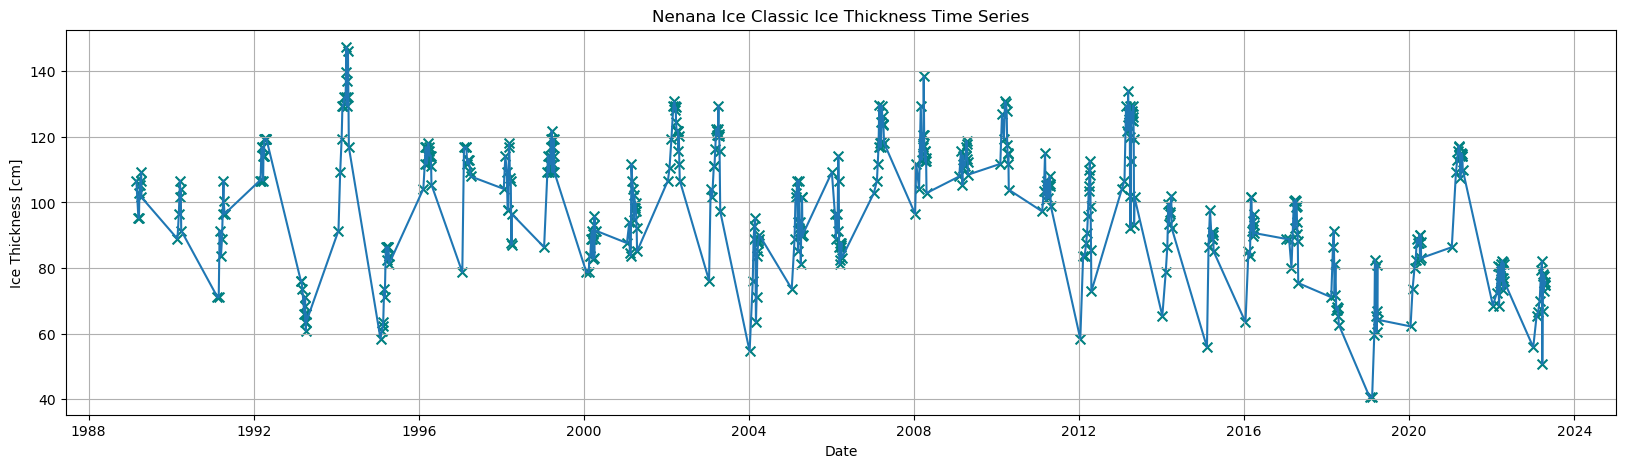

In [48]:
Ice_thickness=Data['IceThickness [cm]']
Ice_thickness=Ice_thickness.dropna(inplace=False) # drop the missing values

plt.figure(figsize=(20,5))
plt.plot(Ice_thickness)
plt.scatter(Ice_thickness.index,Ice_thickness,color='teal',marker='x',s=50)
plt.title('Nenana Ice Classic Ice Thickness Time Series')
plt.ylabel('Ice Thickness [cm]')
plt.xlabel('Date')
plt.grid()
plt.show()

Instead of vectoring the code and applying the function to the whole time-series, we will group the data by year and apply it to each year. 

Lets use the interactive function so we can zoom-in/scroll to get a better feeling for the data.

In [49]:
column_groups = {
    'Nenana': ['IceThickness [cm]'],
    'Regional':['Regional: Air temperature [C]']}

# Plot the specified columns with default y_domains and focus on a specific date
plot_columns_interactive(Data, column_groups, title="Break up times & Global Variables at Tenana River-Nenana, AK with break-up dates")

## Estimating gradients


In [50]:
def finite_differences(series):
    """Compute forward, central, and backward differences using the step size as days between measurement
    """
   
    days_forward = (series.index.to_series().shift(-1) - series.index.to_series()).dt.days
    days_backward = (series.index.to_series() - series.index.to_series().shift(1)).dt.days
    
    # Forward difference: (f(x+h) - f(x)) / h 
    forward = (series.shift(-1) - series) / days_forward

    # Backward difference: (f(x) - f(x-h)) / h,
    backward = (series - series.shift(1)) / days_backward

    # Central difference: (f(x+h) - f(x-h)) / (h_forward + h_backward)
    central = (series.shift(-1) - series.shift(1)) / (days_forward + days_backward) #
    
    # fixing start/end points
    forward.iloc[-1] = np.nan  
    backward.iloc[0] = np.nan  

    return pd.DataFrame({'forward': forward, 'backward': backward, 'central': central})



In [51]:
result = Ice_thickness.groupby(Ice_thickness.index.year).apply(lambda x: finite_differences(x))
result = result.reset_index(level=0, drop=True)

if we were to implement other methods, we simply create the function and  pass  it in the `apply`. 

For example, using the interpolation from [this notebook](https://github.com/iceclassic/mude/blob/main/book/Part_1/Resampling_%26_Interpolation.ipynb) we could either compute the analytical gradient of the fitted spline, or re-apply the same method above on the interpolated time-series.


### Ploting the gradients,
We can easily change the `xlim` to focus on specific years 

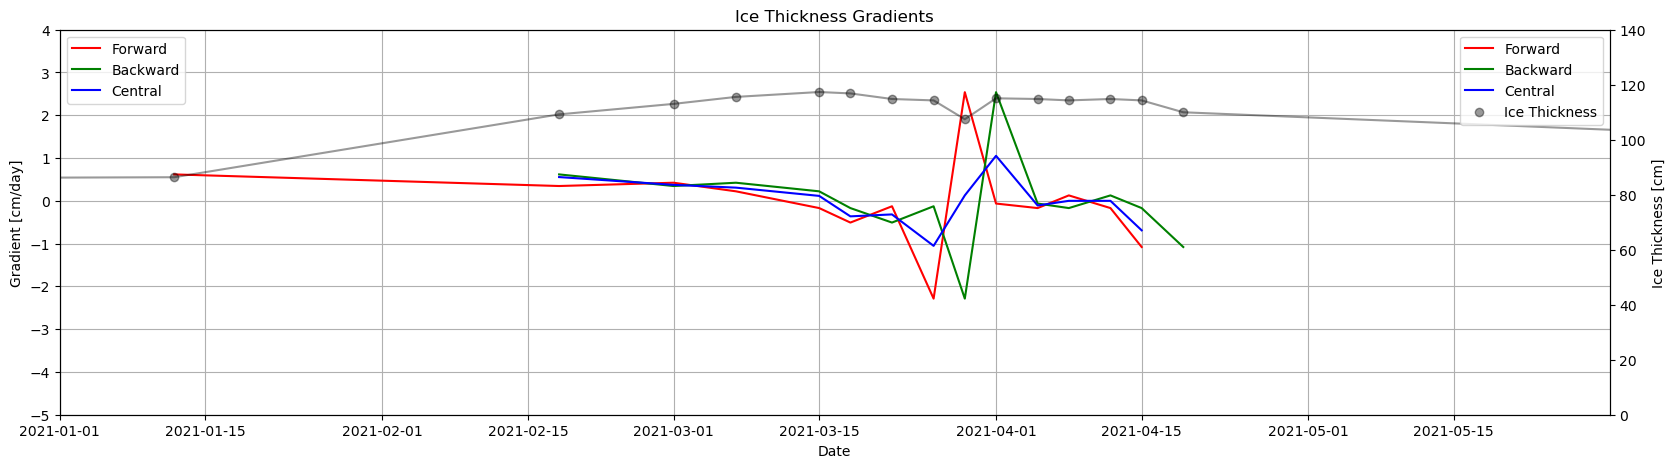

In [52]:
fig, ax1 = plt.subplots(figsize=(20, 5))


ax1.plot(result['forward'], label='Forward', color='red')
ax1.plot(result['backward'], label='Backward', color='green')
ax1.plot(result['central'], label='Central', color='blue')

ax1.set_ylabel('Gradient [cm/day]')
ax1.set_xlabel('Date')
ax1.set_title('Ice Thickness Gradients')
ax1.grid()
ax1.set_ylim([-5, 4])

# change the x-axis to show  a selscted range
ax1.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-05-30'))
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.scatter(Ice_thickness.index, Ice_thickness, color='black', alpha=0.4, label='Ice Thickness')
ax2.plot(Ice_thickness.index, Ice_thickness, color='black', alpha=0.4)
ax2.set_ylabel('Ice Thickness [cm]')
ax2.set_ylim([0, 140])


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

### Plotting the gradient on top of the scatter points

- changing the length in the function changes the size of the 'line'that is represented f the gradient at that point

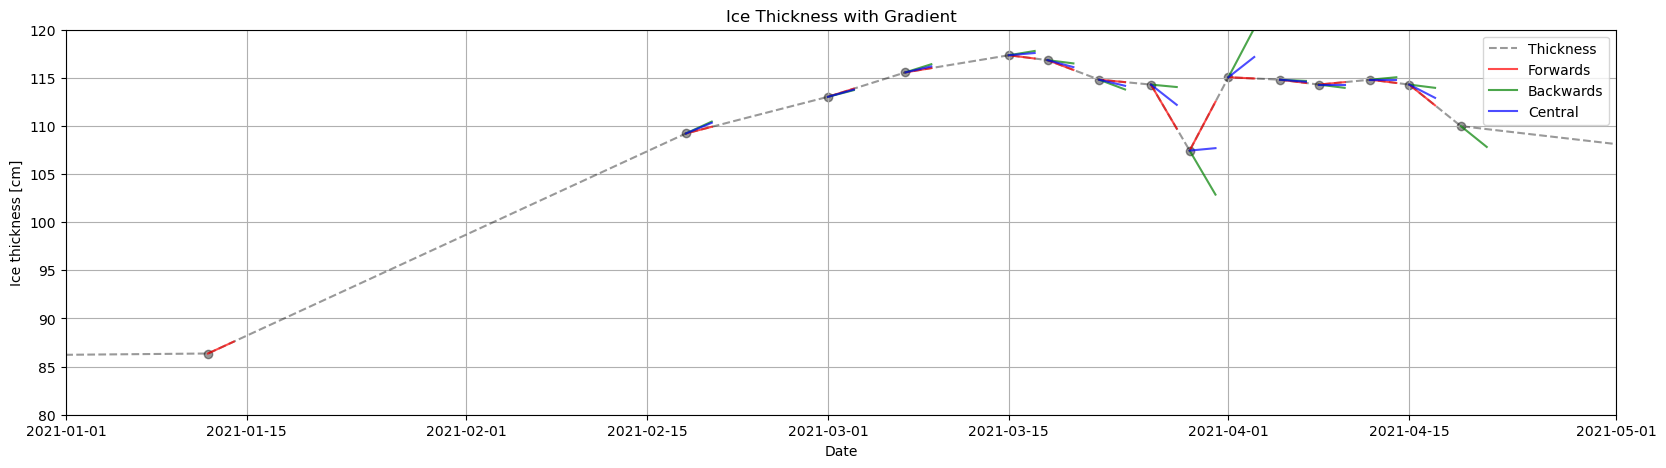

In [53]:
def plot_gradients(ax, x, y, slopes, length=2, label=None, color='blue', label_flag=True):
    """Plot lines with slopes at given points on a plot."""
    for i in range(len(x)):
        if np.isnan(slopes.iloc[i]):
            continue  
        dx = length  
        dy = slopes.iloc[i] * dx  
        # Only label the first line
        ax.plot(
            [x[i], x[i] + pd.Timedelta(days=dx)], 
            [y.iloc[i], y.iloc[i] + dy], 
            color=color, alpha=0.7, label=label if label_flag else ""
        )
        label_flag = False  #  shitty way to avoid the buf that the labels werent showing up

# Plotting the results
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(Ice_thickness.index, Ice_thickness, label='Thickness', color='black', linestyle='--', alpha=0.4)
ax.scatter(Ice_thickness.index, Ice_thickness, color='black', alpha=0.4)

# Plotting gradients with a flag to control label plotting
plot_gradients(ax, result.index, Ice_thickness, result['forward'], color='red', label='Forwards', label_flag=True)
plot_gradients(ax, result.index, Ice_thickness, result['backward'], color='green', label='Backwards', label_flag=True)
plot_gradients(ax, result.index, Ice_thickness, result['central'], color='blue', label='Central', label_flag=True)

ax.legend()
ax.set_title('Ice Thickness with Gradient')
ax.set_xlabel('Date')
ax.set_ylabel('Ice thickness [cm]')
ax.grid(True)
ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-05-01'))
ax.set_ylim([80, 120])
plt.show()
